In [6]:
options(warn=-1)

library(xts)
library(Quandl)
library(dplyr)
library(plotly)
library(lubridate)
library(forecast)
library(TSPred)
library(fGarch)
library(tseries)

### Dowload data using Quandl API

- The API will provide weekly data since 04/08/1990 
- It will form a dataframe which needs to be reversed to in chronological order

In [8]:
qurtly_data = Quandl("CHRIS/CME_NG1", collapse = 'quarterly')
monthly_data = Quandl("CHRIS/CME_NG1", collapse = 'monthly')
daily_data = Quandl("CHRIS/CME_NG1", collapse = 'daily')

In [9]:
qurtly_data <- qurtly_data[rev(rownames(qurtly_data)),]
monthly_data <- monthly_data[rev(rownames(monthly_data)),]
daily_data <- daily_data[rev(rownames(daily_data)),]

In [10]:
head(daily_data)

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
6828,1990-04-03,1.580,1.655,1.580,1.635,NA,1.635,240,110
6827,1990-04-04,1.620,1.650,1.599,1.620,NA,1.620,84,127
6826,1990-04-05,1.615,1.635,1.610,1.615,NA,1.615,57,112
6825,1990-04-06,1.615,1.635,1.610,1.625,NA,1.625,62,136
6824,1990-04-09,1.612,1.640,1.612,1.637,NA,1.637,37,145
6823,1990-04-10,1.625,1.630,1.613,1.620,NA,1.620,29,150


In [11]:
tail(daily_data)

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
6,2017-06-21,2.897,2.948,2.878,2.892,0.014,2.893,135941,98974
5,2017-06-22,2.896,2.962,2.855,2.897,0.001,2.894,141977,78194
4,2017-06-23,2.898,2.940,2.895,2.921,0.035,2.929,86777,49392
3,2017-06-26,2.990,3.052,2.975,3.047,NA,3.027,61332,26928
2,2017-06-27,3.049,3.060,3.012,3.020,0.010,3.037,44524,21360
1,2017-06-28,3.020,3.080,3.016,3.064,0.030,3.067,10609,7063


In [12]:
dim(qurtly_data)
dim(monthly_data)
dim(daily_data)

[1] 109   9

[1] 327   9

[1] 6828    9

In [13]:
p1 <- plot_ly(daily_data, x = ~Date, y = ~Open, type = 'scatter', mode = 'lines') %>%
        layout(title = "Natural Gas Prices Chart",
         xaxis = list(title = "Year"),
         yaxis = list (title = "Price in US$ per Million BTU"))
p1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### Convert the dataframe into a time series and check properties

In [14]:
#qurtly_ts <- ts(qurtly_data$Open, frequency=4, start = decimal_date(ymd("1990-06-30")))
#monthly_ts <- ts(monthly_data$Open, frequency=12, start = decimal_date(ymd("1990-04-30")))
daily_ts <- ts(daily_data$Open)

The ***augmented Dickey-Fuller (ADF)*** test is a formal statistical test for stationarity. The null hypothesis assumes that the series is non-stationary. ADF procedure tests whether the change in Y can be explained by lagged value and a linear trend. If contribution of the lagged value to the change in Y is non-significant and there is a presence of a trend component, the series is non-stationary and null hypothesis will not be rejected.

In [15]:
adf.test(daily_ts, alternative = "stationary")


	Augmented Dickey-Fuller Test

data:  daily_ts
Dickey-Fuller = -3.2186, Lag order = 18, p-value = 0.08461
alternative hypothesis: stationary


This means that the series is not stationary. Usually, non-stationary series can be corrected by a simple transformation such as differencing. Differencing the series can help in removing its trend or cycles. The idea behind differencing is that, if the original data series does not have constant properties over time, then the change from one period to another might. 


	Augmented Dickey-Fuller Test

data:  daily_dff1
Dickey-Fuller = -18.307, Lag order = 18, p-value = 0.01
alternative hypothesis: stationary


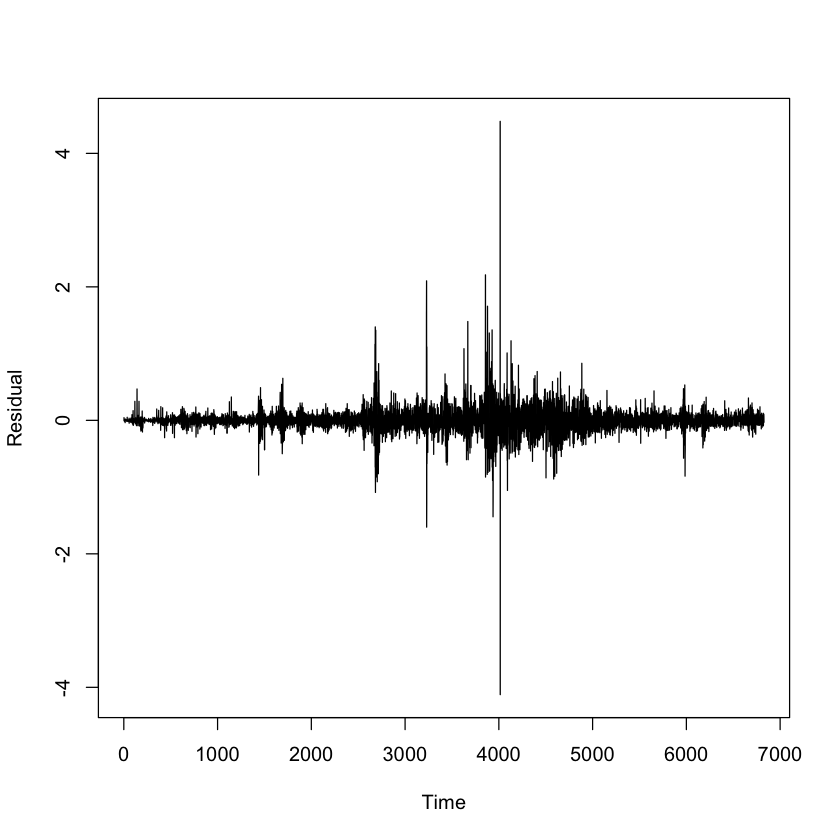

In [16]:
daily_dff1 = diff(daily_ts, differences = 1)
adf.test(daily_dff1, alternative = "stationary")

plot(daily_dff1, ylab="Residual")

In [17]:
summary(daily_dff1)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-4.110000 -0.061000  0.000000  0.000211  0.060000  4.480000 

The mean is close to 0 and Dickey-Fuller Test suggests that the null hypothesis can be rejected. That is TS is close to being a stationary and differencing parameter ***d = 1***

*** Autocorrelations and Choosing Model Order ***

Autocorrelation plots (also known as ACF or the auto correlation function) are a useful visual tool in determining whether a series is stationary. These plots can also help to choose the order parameters for ARIMA model. If the series is correlated with its lags then, generally, there are some trend or seasonal components and therefore its statistical properties are not constant over time.

ACF plots display correlation between a series and its lags. In addition to suggesting the order of differencing, ACF plots can help in determining the order of the MA (q) model. Partial autocorrelation plots (PACF), as the name suggests, display correlation between a variable and its lags that is not explained by previous lags. PACF plots are useful when determining the order of the AR(p) model.

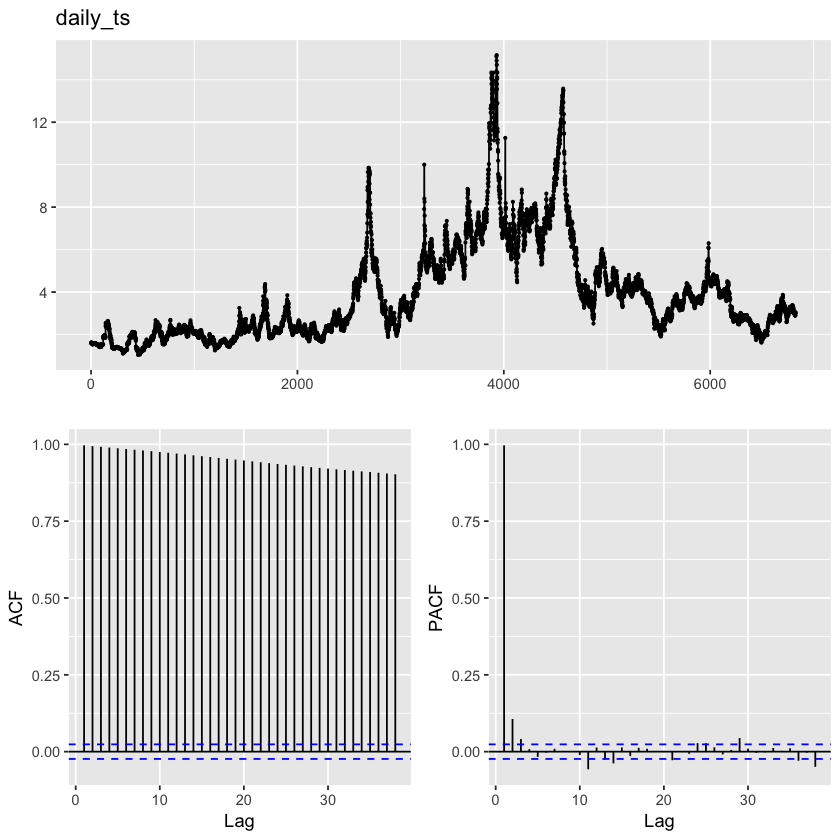

In [18]:
# Inspect ACF and PACF

ggtsdisplay(daily_ts)

#### Auto-correlation of residual

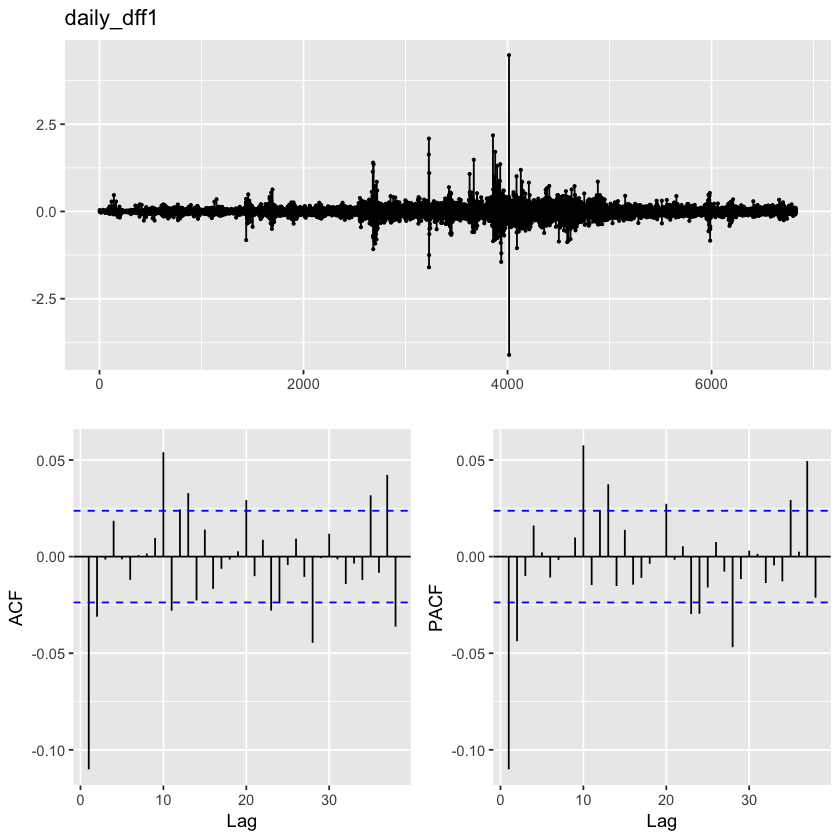

In [19]:
ggtsdisplay(daily_dff1)

There are significant auto correlations at lag 1 and 2 and beyond. Partial correlation plots show a significant spike at lag 10. This suggests that we might want to test models with AR or MA components of order 1, 2, or 10. 


Call:
arima(x = daily_ts, order = c(10, 1, 13))

Coefficients:
         ar1     ar2      ar3      ar4      ar5     ar6     ar7      ar8
      -0.075  0.0270  -0.3949  -0.4513  -0.0446  0.0578  0.2496  -0.3495
s.e.   0.205  0.1222   0.1022   0.0837   0.1137  0.1229  0.0761   0.0982
          ar9    ar10      ma1      ma2     ma3     ma4      ma5      ma6
      -0.1215  0.4881  -0.0399  -0.0677  0.3957  0.4240  -0.0216  -0.0826
s.e.   0.0649  0.1817   0.2046   0.1055  0.1142  0.0665   0.0956   0.1206
          ma7     ma8     ma9     ma10    ma11    ma12    ma13
      -0.2456  0.3954  0.1043  -0.4712  0.0419  0.0482  0.0601
s.e.   0.0590  0.0933  0.0676   0.1767  0.0228  0.0120  0.0191

sigma^2 estimated as 0.03244:  log likelihood = 2015.69,  aic = -3983.37

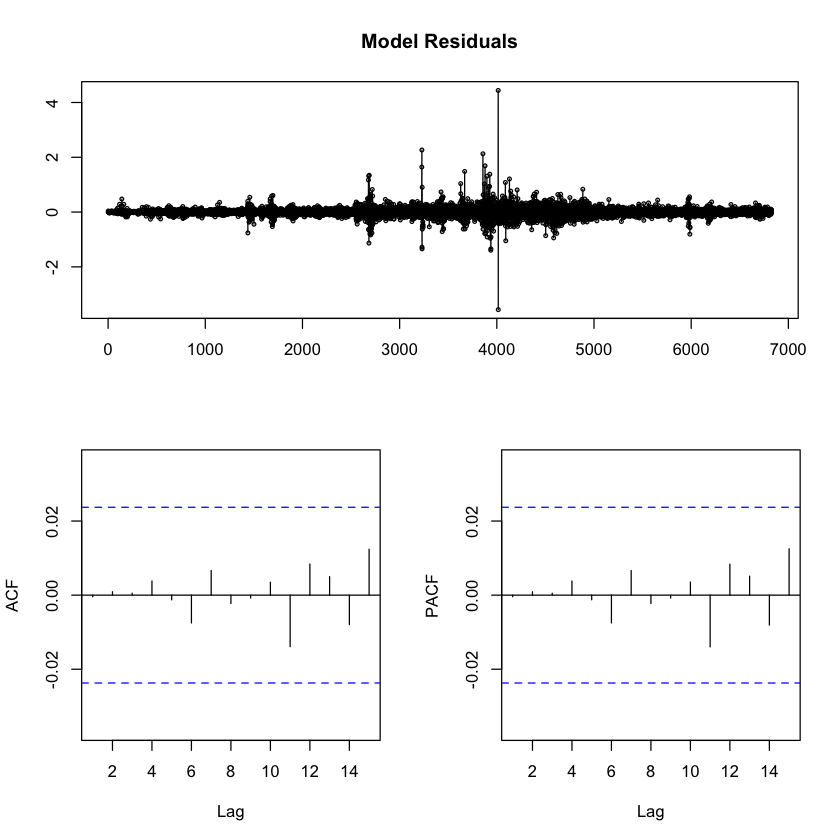

In [20]:
fit_daily = arima(daily_ts, order=c(10,1,13))
fit_daily

tsdisplay(residuals(fit_daily), lag.max=15, main='Model Residuals')

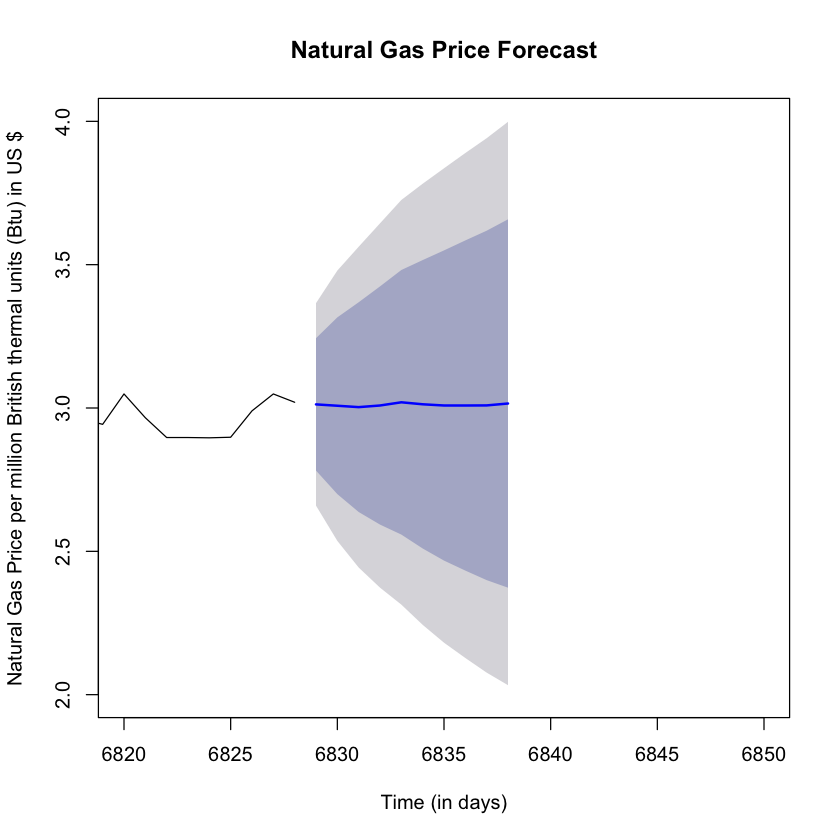

In [29]:
fcast_daily <- forecast(fit_daily, h=10)
plot(fcast_daily, xlim = c(6820, 6850), ylim = c(2,4), xlab = "Time (in days)", 
     ylab = "Natural Gas Price per million British thermal units (Btu) in US $", 
    main = "Natural Gas Price Forecast")

In [27]:
fcast_daily

     Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
6829       3.012611 2.781796 3.243425 2.659610 3.365611
6830       3.007880 2.699642 3.316118 2.536470 3.479290
6831       3.003036 2.637274 3.368798 2.443652 3.562420
6832       3.008740 2.593336 3.424143 2.373435 3.644045
6833       3.019911 2.558477 3.481346 2.314208 3.725614
6834       3.012976 2.509985 3.515968 2.243717 3.782235
6835       3.008750 2.467766 3.549734 2.181386 3.836114
6836       3.008714 2.432852 3.584576 2.128009 3.889419
6837       3.009026 2.399582 3.618470 2.076961 3.941090
6838       3.015688 2.373223 3.658154 2.033122 3.998255

***Conclusion***: The predicted opening price of Nautral Gas on June 29, 2017 is \$3.01 per million British thermal units (Btu) with 80% confidence interval of $ (2.78 - 3.24).